In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#### Everything from adam_simple_prediction 

In [2]:
crime_chicago = pd.read_pickle('crime_chicago_with_timestamp.pkl')

In [3]:
number_of_bins = 70
no = number_of_bins

lat_min = crime_chicago['Latitude'].min()
lon_min = crime_chicago['Longitude'].min()

lat_span = crime_chicago['Latitude'].max() - crime_chicago['Latitude'].min()
lon_span = crime_chicago['Longitude'].max() - crime_chicago['Longitude'].min()

lat_step = lat_span / no
lon_step = lon_span / no

crime_chicago['bin'] = \
    no*np.floor((crime_chicago['Longitude']-lon_min)/lon_step) + \
       np.floor((crime_chicago['Latitude'] -lat_min)/lat_step)

In [4]:
def getPolygonForBin(bin_no):
    lat, lon = getCornerLatLonForBin(bin_no)
    return Polygon([
            (lat,            lon),
            (lat,            lon + lon_step),
            (lat + lat_step, lon + lon_step),
            (lat + lat_step, lon),
        ])
def getPolygonForBinReverse(bin_no):
    lat, lon = getCornerLatLonForBin(bin_no)
    return Polygon([
            (lon,            lat),
            (lon + lon_step, lat),
            (lon + lon_step, lat + lat_step),
            (lon,            lat + lat_step),
        ])

# THEFTS ONLY

In [24]:
crime_chicago_copy = crime_chicago.copy()

In [22]:
crime_chicago['Primary Type'].unique()

array(['NARCOTICS', 'ASSAULT', 'WEAPONS VIOLATION', 'OTHER OFFENSE',
       'BURGLARY', 'THEFT', 'ROBBERY', 'BATTERY', 'MOTOR VEHICLE THEFT',
       'CRIMINAL DAMAGE', 'PUBLIC PEACE VIOLATION', 'CRIMINAL TRESPASS',
       'INTERFERENCE WITH PUBLIC OFFICER', 'DECEPTIVE PRACTICE',
       'OFFENSE INVOLVING CHILDREN', 'CRIM SEXUAL ASSAULT', 'SEX OFFENSE',
       'KIDNAPPING', 'HOMICIDE', 'OBSCENITY', 'LIQUOR LAW VIOLATION',
       'ARSON', 'PROSTITUTION', 'NON-CRIMINAL', 'INTIMIDATION', 'STALKING',
       'NON - CRIMINAL', 'PUBLIC INDECENCY',
       'CONCEALED CARRY LICENSE VIOLATION', 'GAMBLING',
       'HUMAN TRAFFICKING', 'OTHER NARCOTIC VIOLATION',
       'NON-CRIMINAL (SUBJECT SPECIFIED)', 'RITUALISM', 'DOMESTIC VIOLENCE'], dtype=object)

In [25]:
crime_chicago = crime_chicago[crime_chicago['Primary Type'] == 'THEFT']

In [26]:
crime_chicago.index = pd.DatetimeIndex(crime_chicago['datetime'])
crime_chicago_count = crime_chicago[['bin', 'datetime']].groupby(['bin', 'datetime']).size().reset_index().rename(columns={0:'count'})
crime_chicago_count.index = pd.DatetimeIndex(crime_chicago_count['datetime'])

Importing weather data

In [27]:
weather_chicago = pd.read_csv('WeatherChicago20012016.csv')

def weather_date_to_datetime(date):
    return pd.datetime(int(date[0:4]), int(date[4:6]), int(date[6:]))

weather_chicago['DATE'] = weather_chicago['DATE'].map(lambda x: weather_date_to_datetime(str(x)))
weather_chicago.index = pd.DatetimeIndex(weather_chicago['DATE'])
tmin_mean = weather_chicago['TMIN'].mean()
tmax_mean = weather_chicago['TMAX'].mean()

weather_chicago.loc[weather_chicago['TMIN'] == -9999, ['TMIN']] = tmin_mean
weather_chicago.loc[weather_chicago['TMAX'] == -9999, ['TMAX']] = tmax_mean
weather_chicago.loc[weather_chicago['PRCP'] == -9999, ['PRCP']] = 0
weather_chicago.loc[weather_chicago['AWND'] == -9999, ['AWND']] = 0

Concatenating crimes and weather  
Finding empty records

In [28]:
crime_chicago_count_ref = crime_chicago[['datetime']].groupby(['datetime']).size().reset_index().rename(columns={0:'count'})
crime_chicago_count_ref.index = pd.DatetimeIndex(crime_chicago_count_ref['datetime'])
crime_chicago_count_weather = crime_chicago_count_ref.join(weather_chicago[['PRCP', 'TMAX','AWND']])
indeces = pd.isnull(crime_chicago_count_weather).any(1)
crime_chicago_count_weather.drop(crime_chicago_count_weather.index[indeces], inplace=True)

## Prediction

In [96]:
import statsmodels.formula.api as smf
import statsmodels.api as sm
from scipy.stats.stats import pearsonr

In [77]:
crime_chicago_count_weather['weekday'] = crime_chicago_count_weather.index.weekday
crime_chicago_count_weather['yearday'] = crime_chicago_count_weather.index.dayofyear

weekday_dummies = pd.get_dummies(crime_chicago_count_weather['weekday'], prefix='weekday')
weekday_dummies.index = crime_chicago_count_weather.index

yearday_dummies = pd.get_dummies(crime_chicago_count_weather['yearday'], prefix='yearday')
yearday_dummies.index = crime_chicago_count_weather.index

crime_chicago_count_weather_weekdays = crime_chicago_count_weather.join(weekday_dummies).join(yearday_dummies)

In [84]:
crime_chicago_count_weather_weekdays.head(1)

,datetime,count,PRCP,TMAX,AWND,weekday,yearday,weekday_0,weekday_1,weekday_2,...,yearday_357,yearday_358,yearday_359,yearday_360,yearday_361,yearday_362,yearday_363,yearday_364,yearday_365,yearday_366
2001-01-01,2001-01-01,400,0,-33,33,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [110]:
endog = crime_chicago_count_weather_weekdays.loc[:, ['TMAX']] #.as_matrix()

In [112]:
exog = crime_chicago_count_weather_weekdays.loc[:, 'yearday_1':] #.as_matrix()
# exog.drop(['weekday', 'yearday'], inplace=True, axis=1)

In [114]:
from statsmodels.graphics.api import abline_plot
def fit_summary_plot_sm(endog, exog):
    res_temp = sm.GLM(endog, exog, family=sm.families.Poisson(link=sm.families.links.log)).fit(maxiter=500)
    print(res_temp.summary())
    nobs = res.nobs
    yhat = res.mu
    y = crime_chicago_count_weather_weekdays.loc[:,'count']

    fig, ax = plt.subplots()
    ax.scatter(yhat, y)
    line_fit = sm.OLS(y, sm.add_constant(yhat, prepend=True)).fit()
    abline_plot(model_results=line_fit, ax=ax)

    plt.axis([0, 500, 0, 500])

    ax.set_title('Model Fit Plot')
    ax.set_ylabel('Observed values')
    ax.set_xlabel('Fitted values')
    
    return yhat

In [118]:
fit_summary_plot_sm(endog, add_constant(exog, prepend=True))

LinAlgError: SVD did not converge

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                 5470
Model:                            GLM   Df Residuals:                     5098
Model Family:                 Poisson   Df Model:                          371
Link Function:                    log   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -39772.
Date:                Thu, 18 Feb 2016   Deviance:                       40143.
Time:                        23:55:03   Pearson chi2:                 3.91e+04
No. Iterations:                     8                                         
                  coef    std err          z      P>|z|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
const           4.6977      0.001   5808.474      0.000         4.696     4.699
weekday_0       0.6876      0.002    306.791     

array([ 188.41073434,  183.7563084 ,  192.44267311, ...,  201.4792193 ,
        174.43573987,  203.13705179])

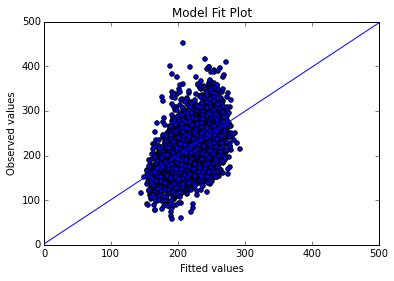

In [109]:
fit_summary_plot_sm(endog, add_constant(exog, prepend=True))

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                 5470
Model:                            GLM   Df Residuals:                     5095
Model Family:                 Poisson   Df Model:                          374
Link Function:                    log   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -39466.
Date:                Thu, 18 Feb 2016   Deviance:                       39531.
Time:                        23:53:06   Pearson chi2:                 3.85e+04
No. Iterations:                     8                                         
                  coef    std err          z      P>|z|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
const           4.6448      0.003   1341.925      0.000         4.638     4.652
PRCP           -0.0002   1.37e-05    -12.370     

array([ 188.41073434,  183.7563084 ,  192.44267311, ...,  201.4792193 ,
        174.43573987,  203.13705179])

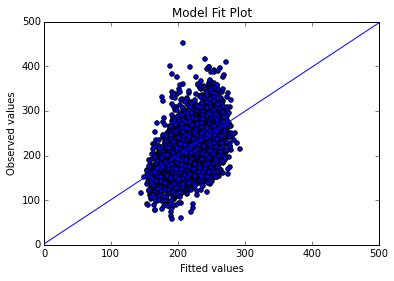

In [107]:
fit_summary_plot_sm(endog, add_constant(exog, prepend=True))

In [52]:
from statsmodels.graphics.api import abline_plot
def fit_summary_plot(formula_temp, dta):
    print(formula_temp)
    res_temp = smf.glm(formula_temp, data=dta, family=sm.families.Poisson(link=sm.families.links.log)).fit()
    print(res_temp.summary())
    nobs = res.nobs
    yhat = res.mu
    y = crime_chicago_count_weather_weekdays.loc[:,'count']

    fig, ax = plt.subplots()
    ax.scatter(yhat, y)
    line_fit = sm.OLS(y, sm.add_constant(yhat, prepend=True)).fit()
    abline_plot(model_results=line_fit, ax=ax)

    plt.axis([0, 500, 0, 500])

    ax.set_title('Model Fit Plot')
    ax.set_ylabel('Observed values')
    ax.set_xlabel('Fitted values')
    
    return yhat

count ~ TMAX + weekday_0 + weekday_1 + weekday_2 + weekday_3 + weekday_4 + weekday_5 + weekday_6
                 Generalized Linear Model Regression Results                  
Dep. Variable:                  count   No. Observations:                 5470
Model:                            GLM   Df Residuals:                     5462
Model Family:                 Poisson   Df Model:                            7
Link Function:                    log   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -43135.
Date:                Thu, 18 Feb 2016   Deviance:                       46868.
Time:                        22:16:30   Pearson chi2:                 4.64e+04
No. Iterations:                     8                                         
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      4.5965      0.001  

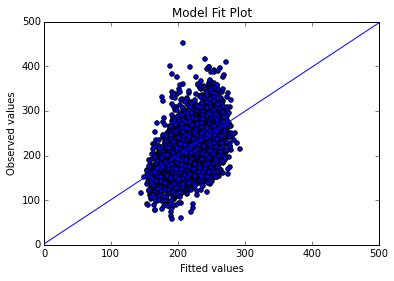

In [55]:
formula = 'count ~ TMAX + weekday_0 + weekday_1 + weekday_2 + weekday_3 + weekday_4 + weekday_5 + weekday_6'
fitted = fit_summary_plot(formula, crime_chicago_count_weather_weekdays)

count ~ weekday_0 + weekday_1 + weekday_2 + weekday_3 + weekday_4 + weekday_5 + weekday_6
                 Generalized Linear Model Regression Results                  
Dep. Variable:                  count   No. Observations:                 5470
Model:                            GLM   Df Residuals:                     5463
Model Family:                 Poisson   Df Model:                            6
Link Function:                    log   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -49218.
Date:                Thu, 18 Feb 2016   Deviance:                       69907.
Time:                        22:15:00   Pearson chi2:                 5.85e+04
No. Iterations:                   100                                         
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept  -5.179e+11   1.18e+11     -4.3

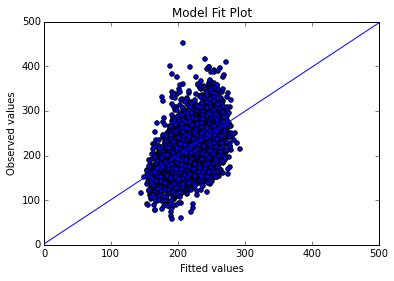

In [51]:
formula = 'count ~ weekday_0 + weekday_1 + weekday_2 + weekday_3 + weekday_4 + weekday_5 + weekday_6'
fit_summary_plot(formula, crime_chicago_count_weather_weekdays)

count ~ TMAX
                 Generalized Linear Model Regression Results                  
Dep. Variable:                  count   No. Observations:                 5470
Model:                            GLM   Df Residuals:                     5468
Model Family:                 Poisson   Df Model:                            1
Link Function:                    log   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -45540.
Date:                Thu, 18 Feb 2016   Deviance:                       51678.
Time:                        22:16:24   Pearson chi2:                 5.13e+04
No. Iterations:                     9                                         
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      5.2565      0.002   3267.037      0.000         5.253     5.260
TMAX           0.0008   7.92e-06    105

array([ 188.41073434,  183.7563084 ,  192.44267311, ...,  201.4792193 ,
        174.43573987,  203.13705179])

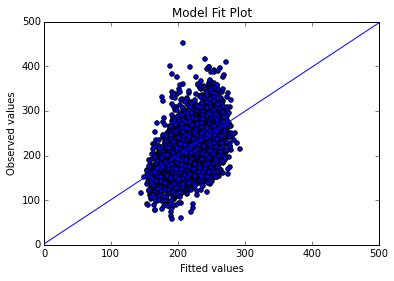

In [54]:
formula = 'count ~ TMAX'
fit_summary_plot(formula, crime_chicago_count_weather_weekdays)

In [58]:
fitted.mean()

219.62047531992727

In [59]:
fitted.var()

641.05131630609037

In [60]:
crime_chicago_count_weather_weekdays.loc[:,'count'].mean()

219.62047531992687

In [66]:
crime_chicago_count_weather_weekdays.loc[:,'count'].std()

49.960829613407462

In [64]:
crime_chicago_count_weather_weekdays.loc[:,'count'].max()

453

- discuss dependence of crime on temperature